# Capstone: West Nile Virus Challenge
 
West Nile virus is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.

In 2002, the first human cases of West Nile virus were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.

Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.

Given weather, location, testing, and spraying data, we are asked to predict when and where different species of mosquitos will test positive for West Nile virus. A more accurate method of predicting outbreaks of West Nile virus in mosquitos will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns',1000)

from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from imblearn.over_sampling import SMOTENC, ADASYN
from imblearn.pipeline import Pipeline, make_pipeline
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.svm import SVC

from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import display
from IPython.display import Image

## Data Loading and Cleaning

### Training and Test data:
The training set consists of data from 2007, 2009, 2011, and 2013, while in the test set we are requested 
to predict the test results for 2008, 2010, 2012, and 2014.

In [7]:
train = pd.read_csv('./datasets/train.csv')

# Make Date into datetime object, and index:
train['Date'] = pd.to_datetime(train.Date, format='%Y-%m-%d')
train.set_index('Date', inplace=True, drop=True)
train.head(1)

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Date,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


We make a note here of the baseline to be bettered through modelling:

In [8]:
print('Baseline = {}'.format(train.WnvPresent.value_counts(normalize=True).max()))
train.WnvPresent.value_counts()

# we can see clearly the problem: only 5% of those traps inspected carried Wnv, can we improve on this?
# we also see a class imbalance here that will need to be resolved before modelling

Baseline = 0.9475537787930707


0    9955
1     551
Name: WnvPresent, dtype: int64

In [9]:
test = pd.read_csv('./datasets/test.csv')
# Make Date into datetime object, and index
test['Date'] = pd.to_datetime(test.Date, format='%Y-%m-%d')
test.set_index('Date', inplace=True, drop=True)
test.head(1)

,Id,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
Date,,,,,,,,,,
2008-06-11,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


### Weather Data:
It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. 
We are provided with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of
the tests. 
    Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
    Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [2]:
weather = pd.read_csv('./datasets/weather.csv')
# Make Date into datetime object, and index
weather['Date'] = pd.to_datetime(weather.Date, format='%Y-%m-%d')
weather.set_index('Date', inplace=True, drop=True)

# Data Cleaning:
weather['Tavg'] = pd.to_numeric(weather.apply(lambda x: (x['Tmin']+x['Tmax'])/2, axis=1))
weather['PrecipTotal'] = pd.to_numeric(weather.apply(lambda x: 0 if x['PrecipTotal']=='  T' or x['PrecipTotal']=='M' else x['PrecipTotal'], axis=1))

# Add Long / Lat:
weather.insert(1,'Latitude', weather.apply(lambda x: 41.995 if x['Station']==1 else 41.786, axis=1))
weather.insert(2,'Longitude', weather.apply(lambda x: -87.933 if x['Station']==1 else -87.752, axis=1))

weather.head()

,Station,Latitude,Longitude,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,41.995,-87.933,83,50,66.5,14,51,56,0,2,0448,1849,,0,M,0.0,0.0,29.10,29.82,1.7,27,9.2
2007-05-01,2,41.786,-87.752,84,52,68.0,M,51,57,0,3,-,-,,M,M,M,0.0,29.18,29.82,2.7,25,9.6
2007-05-02,1,41.995,-87.933,59,42,50.5,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.0,29.38,30.09,13.0,4,13.4
2007-05-02,2,41.786,-87.752,60,43,51.5,M,42,47,13,0,-,-,BR HZ,M,M,M,0.0,29.44,30.08,13.3,2,13.4
2007-05-03,1,41.995,-87.933,66,46,56.0,2,40,48,9,0,0446,1851,,0,M,0.0,0.0,29.39,30.12,11.7,7,11.9


In [3]:
# save to csv for import into Tableau
weather.to_csv(r'./datasets/weather_map.csv')

In [4]:
# Reformatting weather data into flattened version for merging with train data:
weather_station_1 = weather[weather['Station']==1]
weather_station_2 = weather[weather['Station']==2]

weather_df = weather_station_1.merge(weather_station_2,
                                     how='inner',
                                     on='Date',
                                     suffixes=('_station_1','_station_2'))

weather_df.head(1)

,Station_station_1,Latitude_station_1,Longitude_station_1,Tmax_station_1,Tmin_station_1,Tavg_station_1,Depart_station_1,DewPoint_station_1,WetBulb_station_1,Heat_station_1,Cool_station_1,Sunrise_station_1,Sunset_station_1,CodeSum_station_1,Depth_station_1,Water1_station_1,SnowFall_station_1,PrecipTotal_station_1,StnPressure_station_1,SeaLevel_station_1,ResultSpeed_station_1,ResultDir_station_1,AvgSpeed_station_1,Station_station_2,Latitude_station_2,Longitude_station_2,Tmax_station_2,Tmin_station_2,Tavg_station_2,Depart_station_2,DewPoint_station_2,WetBulb_station_2,Heat_station_2,Cool_station_2,Sunrise_station_2,Sunset_station_2,CodeSum_station_2,Depth_station_2,Water1_station_2,SnowFall_station_2,PrecipTotal_station_2,StnPressure_station_2,SeaLevel_station_2,ResultSpeed_station_2,ResultDir_station_2,AvgSpeed_station_2
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,41.995,-87.933,83,50,66.5,14,51,56,0,2,0448,1849,,0,M,0.0,0.0,29.10,29.82,1.7,27,9.2,2,41.786,-87.752,84,52,68.0,M,51,57,0,3,-,-,,M,M,M,0.0,29.18,29.82,2.7,25,9.6


#### PCA
Many weather features to comprehend, can we use PCA to come to a more concise formulation?
We will use the cumulated explained_variance_ratio to test this

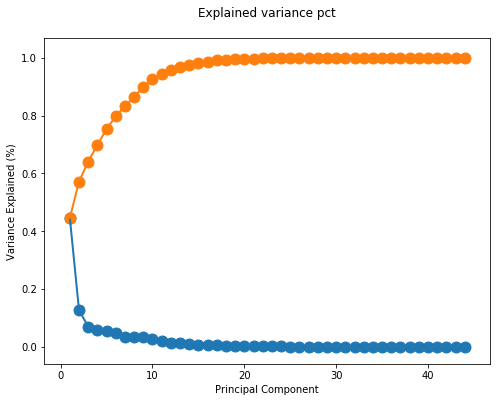

In [5]:
# Prepare a weather_pca dataframe with string dtypes converted to numeric, and standardise:
weather_pca = weather_df.drop(columns=['CodeSum_station_1','CodeSum_station_2']).replace({'M':0,'  T':0, '-':0}).apply(pd.to_numeric)
scaler = StandardScaler()
weather_pca = pd.DataFrame(scaler.fit_transform(weather_pca), columns=weather_pca.columns)

# Fit PCA model and assess:
pca = PCA()
pca.fit(weather_pca)

# Plot the explained_variance_ratio_
plt.figure(figsize=(8,6))
x_values = list(range(1, pca.n_components_+1))
plt.plot(x_values, pca.explained_variance_ratio_, lw=2)
plt.scatter(x_values, pca.explained_variance_ratio_, s=120)
plt.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2)
plt.scatter(x_values, np.cumsum(pca.explained_variance_ratio_), s=120)
plt.title('Explained variance pct\n')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.show()

In [6]:
weather_dict = {'PC'+str(i+1): pca.components_[i] for i in range(len(pca.components_))}
weather_pca_df = pd.DataFrame(weather_dict, index=weather_pca.columns)

weather_pcs = pd.DataFrame(pca.transform(weather_pca),
                           columns=['weather_PC'+str(i+1) for i in range(len(weather_pca.columns))],
                           index=weather_df.index)
weather_pcs.head(1)

,weather_PC1,weather_PC2,weather_PC3,weather_PC4,weather_PC5,weather_PC6,weather_PC7,weather_PC8,weather_PC9,weather_PC10,weather_PC11,weather_PC12,weather_PC13,weather_PC14,weather_PC15,weather_PC16,weather_PC17,weather_PC18,weather_PC19,weather_PC20,weather_PC21,weather_PC22,weather_PC23,weather_PC24,weather_PC25,weather_PC26,weather_PC27,weather_PC28,weather_PC29,weather_PC30,weather_PC31,weather_PC32,weather_PC33,weather_PC34,weather_PC35,weather_PC36,weather_PC37,weather_PC38,weather_PC39,weather_PC40,weather_PC41,weather_PC42,weather_PC43,weather_PC44
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,-0.251913,-0.793374,-1.037595,-0.5602,0.535667,-0.614264,0.0192,-0.408029,-0.182642,1.356595,1.92432,0.039786,-0.144168,-1.288963,0.078154,1.097449,-0.452677,-0.504728,0.036422,0.103453,0.142123,0.121973,-0.0053,-0.072894,-0.029015,-0.022454,0.005875,-0.019996,-3.066616e-15,4.755845e-18,1.211648e-16,5.867437e-17,-5.126796e-17,4.342886e-17,6.105692e-18,-2.128361e-17,9.176080e-18,8.435039e-30,-8.163921e-33,-7.729338e-33,-7.709365e-34,2.396243e-33,-2.470815e-16,-7.519899e-17


### Spray Data

The City of Chicago also does spraying to kill mosquitos. We are given the GIS data for their spray efforts
in 2011 and 2013. Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus.

In [10]:
spray = pd.read_csv('./datasets/spray.csv')
# Make Date into datetime object, and index
spray['Date'] = pd.to_datetime(spray.Date, format='%Y-%m-%d')
spray.set_index('Date', inplace=True, drop=True)
spray.drop(columns='Time', inplace=True)
spray.head(1)

,Latitude,Longitude
Date,,
2011-08-29,42.391623,-88.089163


## EDA: charting and analysing data

In [11]:
# Merging weather data onto train data:
train_df = train.merge(weather_df, how='left', on='Date', suffixes=('',''))
# Merging weather_pcs data onto train data:
train_df = train_df.merge(weather_pcs, how='left', on='Date', suffixes=('',''))
train_df.head(1)

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Station_station_1,Latitude_station_1,Longitude_station_1,Tmax_station_1,Tmin_station_1,Tavg_station_1,Depart_station_1,DewPoint_station_1,WetBulb_station_1,Heat_station_1,Cool_station_1,Sunrise_station_1,Sunset_station_1,CodeSum_station_1,Depth_station_1,Water1_station_1,SnowFall_station_1,PrecipTotal_station_1,StnPressure_station_1,SeaLevel_station_1,ResultSpeed_station_1,ResultDir_station_1,AvgSpeed_station_1,Station_station_2,Latitude_station_2,Longitude_station_2,Tmax_station_2,Tmin_station_2,Tavg_station_2,Depart_station_2,DewPoint_station_2,WetBulb_station_2,Heat_station_2,Cool_station_2,Sunrise_station_2,Sunset_station_2,CodeSum_station_2,Depth_station_2,Water1_station_2,SnowFall_station_2,PrecipTotal_station_2,StnPressure_station_2,SeaLevel_station_2,ResultSpeed_station_2,ResultDir_station_2,AvgSpeed_station_2,weather_PC1,weather_PC2,weather_PC3,weather_PC4,weather_PC5,weather_PC6,weather_PC7,weather_PC8,weather_PC9,weather_PC10,weather_PC11,weather_PC12,weather_PC13,weather_PC14,weather_PC15,weather_PC16,weather_PC17,weather_PC18,weather_PC19,weather_PC20,weather_PC21,weather_PC22,weather_PC23,weather_PC24,weather_PC25,weather_PC26,weather_PC27,weather_PC28,weather_PC29,weather_PC30,weather_PC31,weather_PC32,weather_PC33,weather_PC34,weather_PC35,weather_PC36,weather_PC37,weather_PC38,weather_PC39,weather_PC40,weather_PC41,weather_PC42,weather_PC43,weather_PC44
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,1,41.995,-87.933,88,60,74.0,10,58,65,0,9,0421,1917,BR HZ,0,M,0.0,0.0,29.39,30.11,5.8,18,6.5,2,41.786,-87.752,88,65,76.5,M,59,66,0,12,-,-,BR HZ,M,M,M,0.0,29.44,30.09,5.8,16,7.4,-2.96095,-0.514629,0.118332,-0.802983,-0.076003,-0.257016,-0.210052,0.151524,-0.034767,-0.156731,0.893987,-0.02397,-0.087157,-0.313385,-0.01177,-0.353996,-0.164814,-0.259222,0.227241,0.037671,-0.092248,0.097771,0.023659,0.15449,-0.018202,0.015234,0.008571,0.022098,-4.148041e-16,3.550686e-16,6.351522e-18,-9.787647e-17,2.726637e-16,-6.465551e-18,3.358695e-17,-1.988724e-17,9.793618e-18,-7.744511e-29,1.809939e-32,1.252469e-33,-7.394732e-33,1.837534e-32,-1.966582e-17,-5.307868e-17


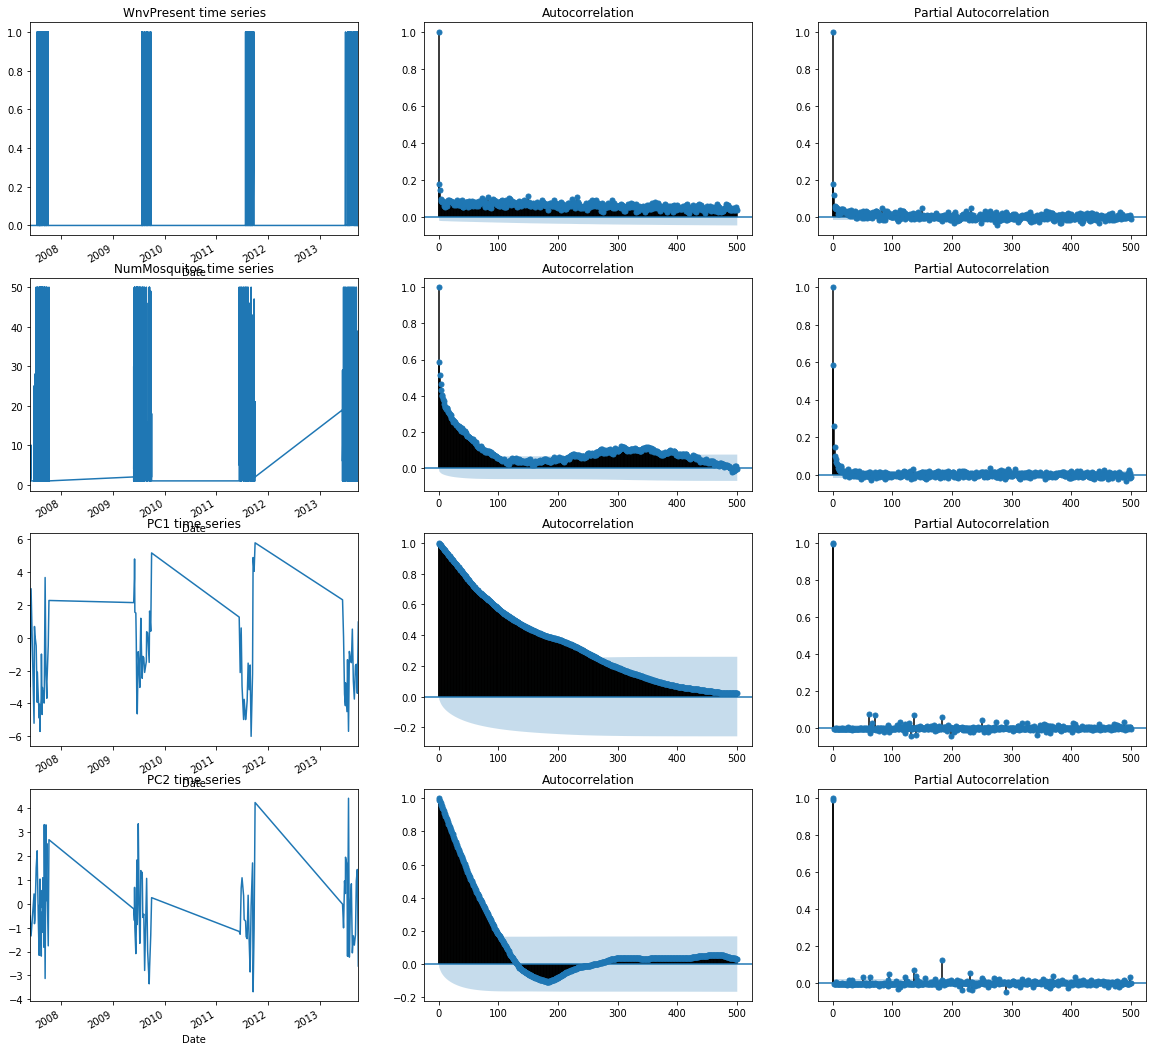

In [12]:
# Plotting a Partial Autocorrelation model to illustrate seasonal effects as Wnv is most prevalent in summer:

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))

train_df['WnvPresent'].plot(ax=ax[0,0], title='WnvPresent time series')
plot_acf(train_df['WnvPresent'], lags=500, ax=ax[0,1])
plot_pacf(train_df['WnvPresent'], lags=500, ax=ax[0,2])

train_df['NumMosquitos'].plot(ax=ax[1,0], title='NumMosquitos time series')
plot_acf(train_df['NumMosquitos'], lags=500, ax=ax[1,1])
plot_pacf(train_df['NumMosquitos'], lags=500, ax=ax[1,2])

train_df['weather_PC1'].plot(ax=ax[2,0], title='PC1 time series')
plot_acf(train_df['weather_PC1'], lags=500, ax=ax[2,1])
plot_pacf(train_df['weather_PC1'], lags=500, ax=ax[2,2])

train_df['weather_PC2'].plot(ax=ax[3,0], title='PC2 time series')
plot_acf(train_df['weather_PC2'], lags=500, ax=ax[3,1])
plot_pacf(train_df['weather_PC2'], lags=500, ax=ax[3,2])

plt.show()

# Interestingly tests in 2013 coupled with higher rate of positives: was Chicago starting to predict
    # better the WNV's whereabouts in 2013?

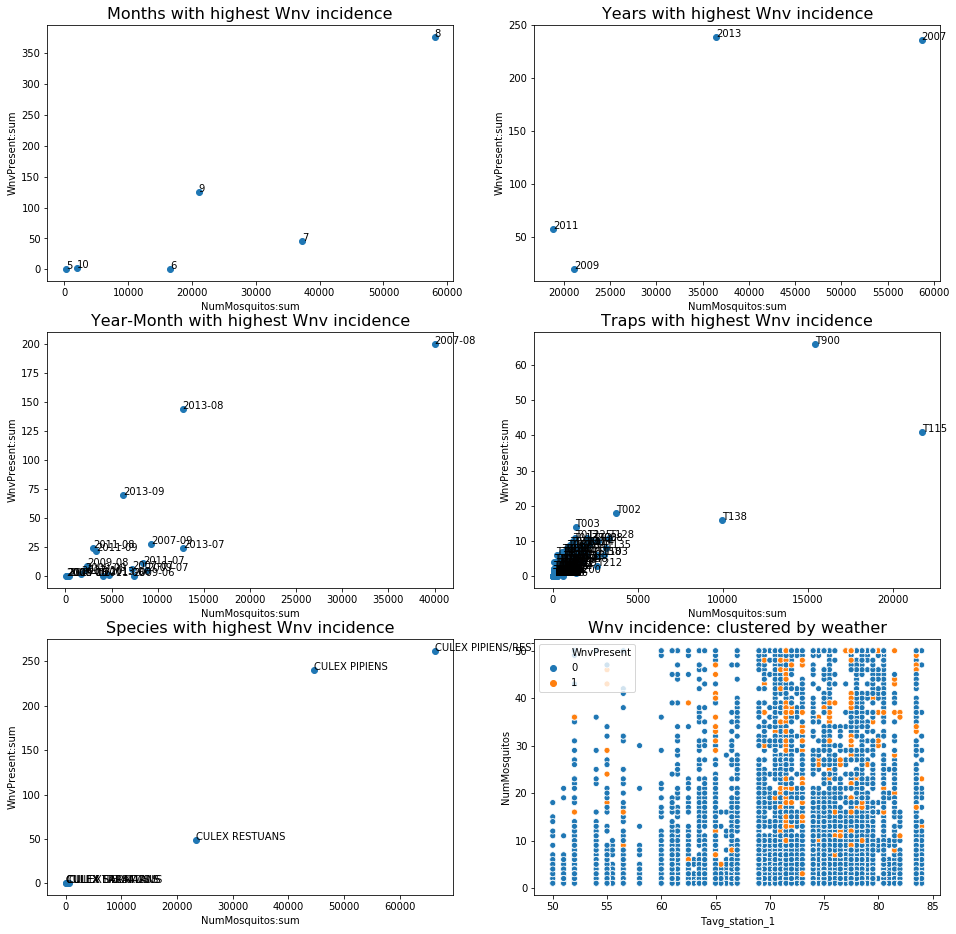

In [15]:
# When (ie, which summer month / which year) had the highest incidence of Wnv and NumMosquitos?
# And where (ie, which trap) had the highest incidence of Wnv and NumMosquitos?

train_month_grp = train.groupby(train.index.month).agg({'WnvPresent':'sum',
                                                        'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                            ascending=False)
train_year_grp = train.groupby(train.index.year).agg({'WnvPresent':'sum',
                                                      'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                          ascending=False)
train_monthyear_grp = train.groupby(train.index.to_period('M')).agg({'WnvPresent':'sum',
                                                                     'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                                         ascending=False)
train_trap_grp = train.groupby('Trap').agg({'WnvPresent':'sum',
                                            'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                ascending=False)
train_species_grp = train.groupby('Species').agg({'WnvPresent':'sum',
                                                  'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                      ascending=False)
# Scatter-plot both sets of data:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,16))
ax[0,0].scatter(train_month_grp['NumMosquitos'], train_month_grp['WnvPresent']);
for i, xi in enumerate(train_month_grp.index):
    ax[0,0].annotate(xi, (train_month_grp.iloc[i,1], train_month_grp.iloc[i,0]))
ax[0,0].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[0,0].set_ylabel('WnvPresent:sum', fontsize=10)
ax[0,0].set_title('Months with highest Wnv incidence', fontsize=16)

ax[0,1].scatter(train_year_grp['NumMosquitos'], train_year_grp['WnvPresent']);
for i, xi in enumerate(train_year_grp.index):
    ax[0,1].annotate(xi, (train_year_grp.iloc[i,1], train_year_grp.iloc[i,0]))
ax[0,1].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[0,1].set_ylabel('WnvPresent:sum', fontsize=10)
ax[0,1].set_title('Years with highest Wnv incidence', fontsize=16)

ax[1,0].scatter(train_monthyear_grp['NumMosquitos'], train_monthyear_grp['WnvPresent']);
for i, xi in enumerate(train_monthyear_grp.index):
    ax[1,0].annotate(xi, (train_monthyear_grp.iloc[i,1], train_monthyear_grp.iloc[i,0]))
ax[1,0].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[1,0].set_ylabel('WnvPresent:sum', fontsize=10)
ax[1,0].set_title('Year-Month with highest Wnv incidence', fontsize=16)

ax[1,1].scatter(train_trap_grp['NumMosquitos'], train_trap_grp['WnvPresent']);
for i, xi in enumerate(train_trap_grp.index):
    ax[1,1].annotate(xi, (train_trap_grp.iloc[i,1], train_trap_grp.iloc[i,0]))
ax[1,1].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[1,1].set_ylabel('WnvPresent:sum', fontsize=10)
ax[1,1].set_title('Traps with highest Wnv incidence', fontsize=16)

ax[2,0].scatter(train_species_grp['NumMosquitos'], train_species_grp['WnvPresent']);
for i, xi in enumerate(train_species_grp.index):
    ax[2,0].annotate(xi, (train_species_grp.iloc[i,1], train_species_grp.iloc[i,0]))
ax[2,0].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[2,0].set_ylabel('WnvPresent:sum', fontsize=10)
ax[2,0].set_title('Species with highest Wnv incidence', fontsize=16)

sns.scatterplot(train_df['Tavg_station_1'], train_df['NumMosquitos'], hue=train_df['WnvPresent'], ax=ax[2,1]);
ax[2,1].set_xlabel('Tavg_station_1', fontsize=10)
ax[2,1].set_ylabel('NumMosquitos', fontsize=10)
ax[2,1].set_title('Wnv incidence: clustered by weather', fontsize=16)

plt.show();

# Clear to see that both Wnv and NumMosquitos was highest in certain Traps, years, and months.

## Modelling

### Decision Tree Classifier: Temp, Rainfall

In [18]:
# ADASYN to deal with class imbalance:
ad = ADASYN()

# Decision Tree classifier:
dt = DecisionTreeClassifier(max_depth=4, random_state=1)

# Simple pipeline set-up - in order to ensure that cross-val scoring has resampling applied to training folds
pipeline = Pipeline([('ad', ad), ('dt', dt)])

# Set up X, y:
y, X = train_df['WnvPresent'], train_df[['weather_PC1','weather_PC2', 'weather_PC3', 'weather_PC4']]

# Fit pipeline:
pipeline.fit(X, y)

# Scoring pipeline:
print('Training score:',pipeline.score(X, y))

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
print('CV KF score:',cross_val_score(pipeline, X, y, cv=kf).mean())
ts = TimeSeriesSplit(n_splits=5)
print('CV TS score:',cross_val_score(pipeline, X, y, cv=ts).mean())

predictions = pipeline.predict(X)
print(' ')
print('Confusion Matrix:')
print(confusion_matrix(y, predictions, labels=[0,1]))
print(' ')
print('Classification Report:')
print(classification_report(y, predictions))

Training score: 0.5545402627070246
CV KF score: 0.5946998189888282
CV TS score: 0.6310679611650486
 
Confusion Matrix:
[[5351 4604]
 [  76  475]]
 
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.54      0.70      9955
           1       0.09      0.86      0.17       551

    accuracy                           0.55     10506
   macro avg       0.54      0.70      0.43     10506
weighted avg       0.94      0.55      0.67     10506



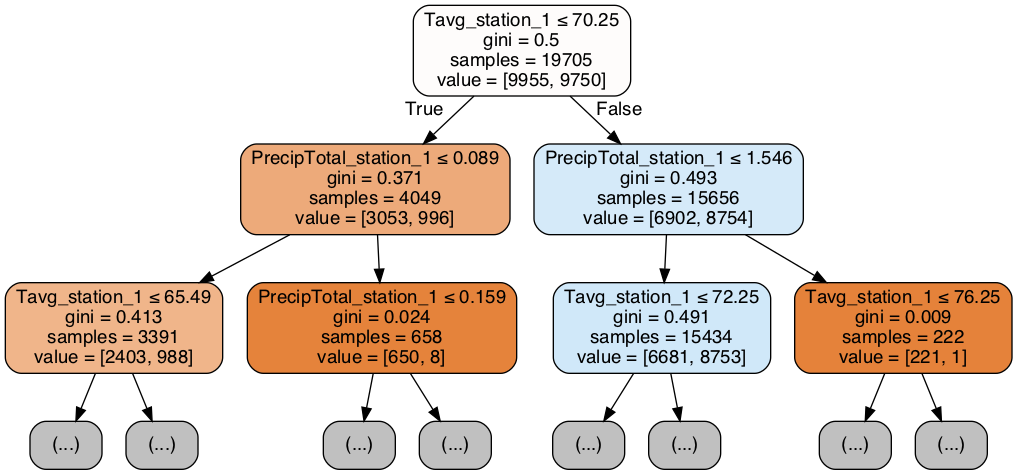

In [56]:
# Plot the Decision Tree:
dot_data = StringIO()
export_graphviz(dt,
                out_file=dot_data,
                max_depth=2,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=['Tavg_station_1','PrecipTotal_station_1']
                )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

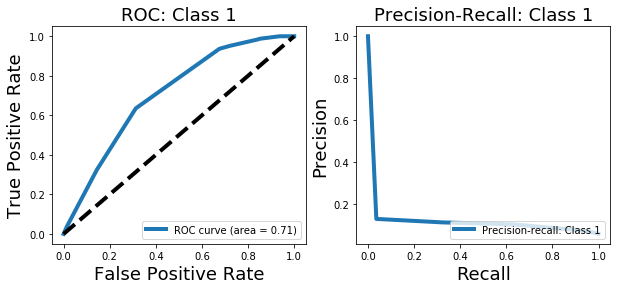

In [57]:
# Create predicted probabilities dataframe
y_pp = pd.DataFrame(pipeline.predict_proba(X[['Tavg_station_1','PrecipTotal_station_1']]),
                    columns=['class_0_pp', 'class_1_pp'])

# ROC curve
fpr, tpr, threshold = roc_curve(y, y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

# Plot for class 1
fig, ax = plt.subplots(ncols=2, figsize=[10, 4])
ax[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
ax[0].plot([0, 1], [0, 1], 'k--', linewidth=4)
ax[0].set_xlabel('False Positive Rate', fontsize=18)
ax[0].set_ylabel('True Positive Rate', fontsize=18)
ax[0].legend(loc="lower right")
ax[0].set_title('ROC: Class 1', fontsize=18)

# Precision-Recall curve:
precision, recall, threshold = precision_recall_curve(y, y_pp.class_1_pp)

# Plot for class 1
ax[1].plot(recall, precision, label='Precision-recall: Class 1', linewidth=4)
ax[1].set_xlabel('Recall', fontsize=18)
ax[1].set_ylabel('Precision', fontsize=18)
ax[1].set_title('Precision-Recall: Class 1', fontsize=18)
ax[1].legend(loc="lower right")
plt.show();

### Decision Tree Classifier: Temp, Rainfall, Trap

In [22]:
# Add in the categorical location feature:

# y, X = train_df['WnvPresent'], train_df[['Trap','Tavg_station_1','PrecipTotal_station_1']]
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
X = train_df[['Trap','weather_PC1','weather_PC2','WnvPresent']]
trap_list = list(train_trap_grp[train_trap_grp['WnvPresent']>1].index)
X = X[X['Trap'].isin(trap_list)]
X_train, X_test = train_test_split(X, stratify=X[['Trap','WnvPresent']])

y_train = X_train.pop('WnvPresent')
y_test = X_test.pop('WnvPresent')

sm = SMOTENC(categorical_features=[0])
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
X_train_res_dum = pd.get_dummies(X_train_res, columns=['Trap'], drop_first=True)

dt = DecisionTreeClassifier(max_depth=None, random_state=1)
dt.fit(X_train_res_dum, y_train_res)

# Scoring
X_test_dum = pd.get_dummies(X_test, columns=['Trap'], drop_first=True)
print('Validation set score:', dt.score(X_test_dum, y_test))

predictions = dt.predict(X_test_dum)
print(' ')
print('Confusion Matrix:')
print(confusion_matrix(y_test, predictions, labels=[0,1]))
print(' ')
print('Classification Report:')
print(classification_report(y_test, predictions))

Validation set score: 0.8602352941176471
 
Confusion Matrix:
[[1784  220]
 [  77   44]]
 
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      2004
           1       0.17      0.36      0.23       121

    accuracy                           0.86      2125
   macro avg       0.56      0.63      0.58      2125
weighted avg       0.91      0.86      0.88      2125



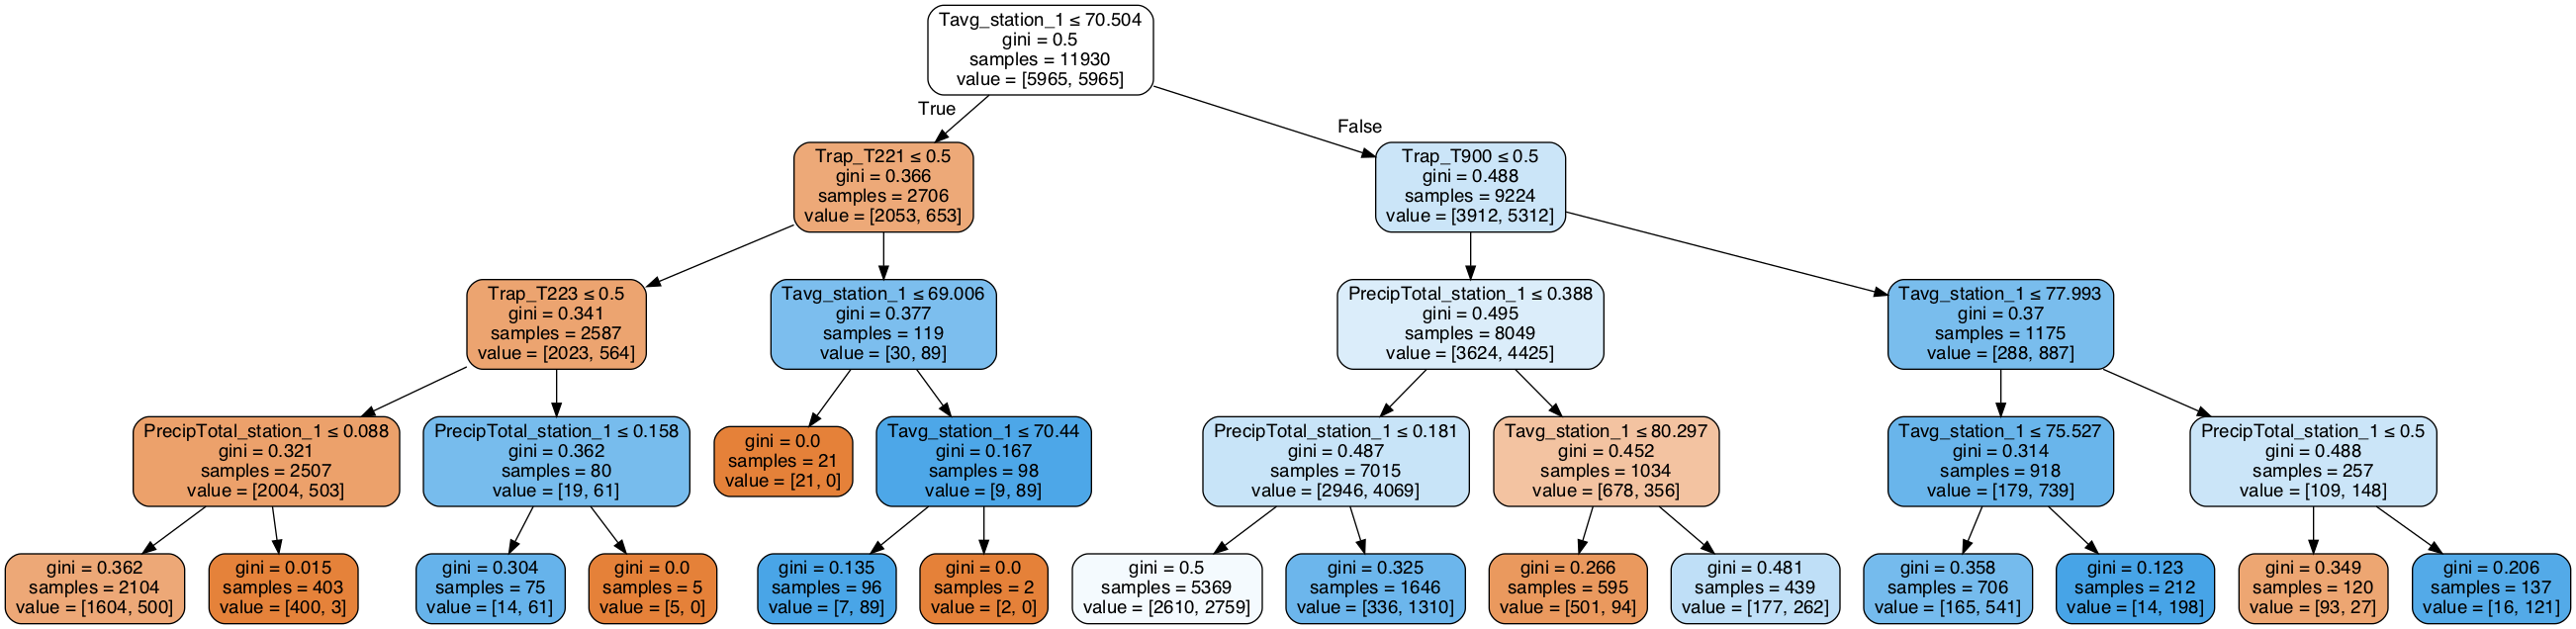

In [68]:
# Plot the Decision Tree:
dot_data = StringIO()
export_graphviz(dt,
                out_file=dot_data,
                max_depth=None,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=X_train_res_dum.columns
                )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

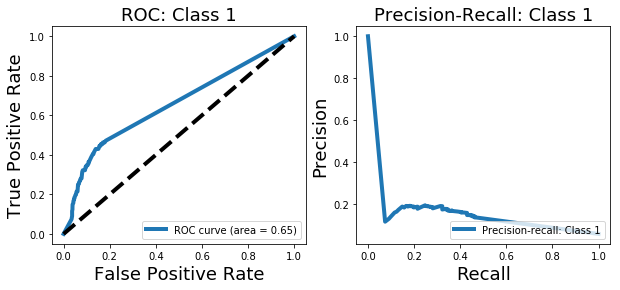

In [24]:
# Create predicted probabilities dataframe
y_pp = pd.DataFrame(dt.predict_proba(X_test_dum),
                    columns=['class_0_pp', 'class_1_pp'])

# ROC curve
fpr, tpr, threshold = roc_curve(y_test, y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)
# Plot for class 1
fig, ax = plt.subplots(ncols=2, figsize=[10, 4])
ax[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
ax[0].plot([0, 1], [0, 1], 'k--', linewidth=4)
ax[0].set_xlabel('False Positive Rate', fontsize=18)
ax[0].set_ylabel('True Positive Rate', fontsize=18)
ax[0].legend(loc="lower right")
ax[0].set_title('ROC: Class 1', fontsize=18)

# Precision-Recall curve:
precision, recall, threshold = precision_recall_curve(y_test, y_pp.class_1_pp)
# Plot for class 1
ax[1].plot(recall, precision, label='Precision-recall: Class 1', linewidth=4)
ax[1].set_xlabel('Recall', fontsize=18)
ax[1].set_ylabel('Precision', fontsize=18)
ax[1].set_title('Precision-Recall: Class 1', fontsize=18)
ax[1].legend(loc="lower right")
plt.show();

In [201]:
feature_importance = pd.DataFrame(dt.feature_importances_,
                                  index=X_train_res_dum.columns,
                                  columns=['importance'])
feature_importance.sort_values('importance',ascending=False).head(10)

# our Decision Tree now predicts Wnv will occur in only 3 of the traps, because we haven't asked enough 
# questions, but any more questions and we run the risk of overfitting. So in this case of many Trap locations
# the DecisionTreeClassifier may not be the best solution, although it highlights that we have too many Traps 
# and will need to generalise to clusters / neighborhoods

,importance
PC2,0.296357
PC1,0.278349
Trap_T900,0.054423
Trap_T221,0.024089
Trap_T115,0.019043
Trap_T114,0.018808
Trap_T008,0.016206
Trap_T003,0.011060
Trap_T903,0.011054
Trap_T223,0.009992


### SVM: Temp, Rainfall, Trap

In [ ]:
# SVM:
scaler = StandardScaler()
Xs_train = scaler.fit_transform(X_train_res_dum)
Xs_test = scaler.transform(X_test_dum)

svm = [SVC(kernel='rbf'),
       SVC(kernel='poly')]
svm_params = [{'C':np.logspace(-4,4,10)},
              {'C':np.logspace(-4,4,10),
               'degree':list(range(2,10))}]

gs = {}
for i in range(len(svm)):
    gs['gs_{}'.format(i)] = GridSearchCV(svm[i], svm_params[i], verbose=1, n_jobs=2, cv=3)
    gs['gs_{}'.format(i)].fit(Xs_train,y_train_res)
    print(gs['gs_{}'.format(i)].best_params_)
    print(gs['gs_{}'.format(i)].best_score_)    
    print(classification_report(y_test, gs['gs_{}'.format(i)].predict(Xs_test)))
    print('Confusion Matrix:')
    print(pd.crosstab(y_test, gs['gs_{}'.format(i)].predict(Xs_test), rownames=['Actual'], colnames=['Predicted'], margins=True))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed: 10.0min finished


{'C': 10000.0}
0.8278001341381623
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      2004
           1       0.10      0.47      0.17       121

    accuracy                           0.74      2125
   macro avg       0.53      0.61      0.51      2125
weighted avg       0.91      0.74      0.81      2125

Confusion Matrix:
Predicted     0    1   All
Actual                    
0          1515  489  2004
1            64   57   121
All        1579  546  2125
Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/Noah/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 52.0min


In [69]:
# To-do:
    # Related to that: try to see why spraying was ineffective e.g. in 2011. Was this on different days? Or was
        # it even on same day and therefore could be affecting different mosquitos?

### Clustering: Trap Locations

In [203]:
# DBSCAN to create clusters based on location:
dbscan = DBSCAN(eps=1.5)
distance_matrix = squareform(pdist(train_df[['Latitude','Longitude']]))
y_db = dbscan.fit_predict(distance_matrix)

print(len(np.unique(dbscan.labels_)))
print(len((dbscan.labels_)))

plt.figure(figsize=(6,10))
plt.scatter(train_df.Longitude, train_df.Latitude,c=dbscan.labels_);

KeyboardInterrupt: 

In [ ]:
# Look at Bagging and Boosting models, and include the PCs in there to see if it improves anything.
# Trap clustering instead of actual Trap location
# Look at the good kernels and what they did in terms of the features included